In [137]:
# Import dependencies 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10, 6)

db_con = psycopg2.connect(
    host="localhost",
    port="5432",
    database="cid_hoarder_n10k_k25",
    user="hoarder",
    password="password")


In [138]:
 cids = pd.read_sql_query("""SELECT cid_hash FROM cid_info;""", db_con) 

In [139]:
ping_rounds = pd.read_sql_query("""
select ping_round, count(ping_round) from ping_results group by ping_round order by ping_round ASC;""", db_con)

In [140]:
# Get the CID Publish times for the CIDs
pub_times = pd.read_sql_query("""
    select cid_hash, gen_time from cid_info order by cid_hash;
    """, db_con)

# Get total pub time 
mn = min(pub_times['gen_time'])
mx = max(pub_times['gen_time'])

pub_t = (mx - mn) / 60 # conver to mins
print(f'{pub_t} mins to publish the CIDs')

7.966666666666667 mins to publish the CIDs


In [141]:
# get the median time of each fetch time
hours_dist = []
for idx, row in ping_rounds.iterrows():
    # get the fetch times
    fetch_round = pd.read_sql_query(f"""
        select cid_hash, fetch_time from fetch_results where ping_round={row['ping_round']} order by cid_hash;
        """, db_con)
    fetch_round['time of pub'] = (fetch_round['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
    pp = fetch_round['time of pub'].to_numpy()
    hours_dist.append(np.median(pp))

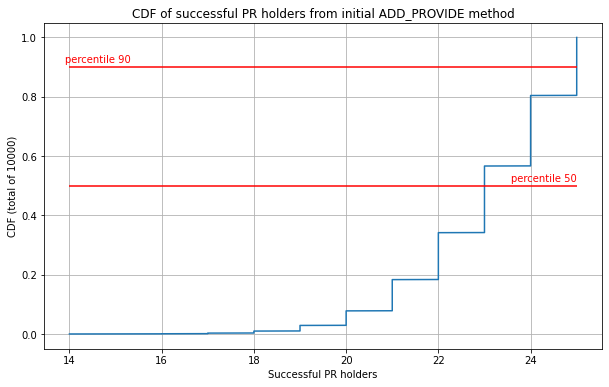

In [142]:
# Get the number of successfull ADD_PR 
pobj = pd.read_sql_query(f"""
select success_att from fetch_results where ping_round=0 order by success_att ASC""", db_con)

per_1 = {'smalest_value': 0.0, 'x': 0.0}

plt.plot(pobj["success_att"], np.linspace(0, 1, len(pobj)))
plt.title("CDF of successful PR holders from initial ADD_PROVIDE method")
plt.xlabel("Successful PR holders")
plt.ylabel(f"CDF (total of {len(cids)})")

# Lines
plt.hlines(y=[0.50], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['success_att'], 0.525, 'percentile 50', ha='right', va='center', color='r')
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[0]['success_att']-0.1, 0.925, 'percentile 90', ha='left', va='center', color='r')

plt.grid()

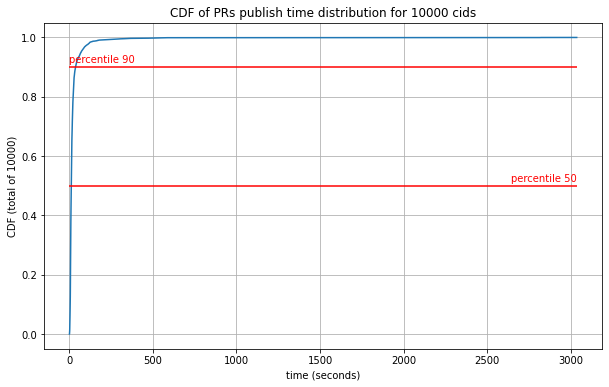

In [143]:
# TODO: Add Percentiles to the top of the graphics

# Get the time to the IPFS DHT Provide method
pobj = pd.read_sql_query("select provide_time from cid_info order by provide_time ASC", db_con)
pobj['provide_time'] = pobj['provide_time'] / 1000  # convert to secods

plt.plot(pobj["provide_time"],np.linspace(0, 1, len(pobj)))
plt.title(f'CDF of PRs publish time distribution for {len(pobj)} cids')
plt.xlabel("time (seconds)")
plt.ylabel(f"CDF (total of {len(pobj)})")

# Lines
plt.hlines(y=[0.50], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['provide_time'], 0.525, 'percentile 50', ha='right', va='center', color='r')
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[0]['provide_time'], 0.925, 'percentile 90', ha='left', va='center', color='r')

plt.grid()

#plt.hist(pobj['provide_time'], cdf_pt)

Text(0, 0.5, 'Number of CIDs')

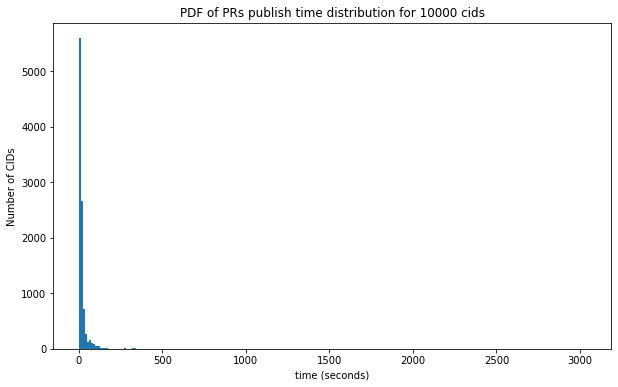

In [144]:
plt.hist(pobj['provide_time'], density=False, bins=256)
plt.title(f'PDF of PRs publish time distribution for {len(pobj)} cids')
plt.xlabel("time (seconds)")
plt.ylabel(f"Number of CIDs")


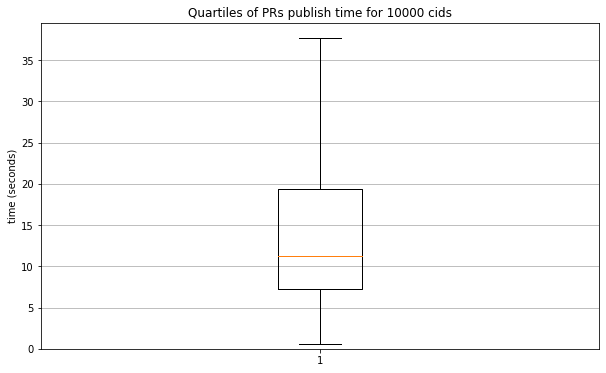

In [145]:
# Quartiles of time to execute IPFS DHT Provide method

fig, ax = plt.subplots()
ax.boxplot(pobj["provide_time"], showfliers=False)
ax.set_ylabel("time (seconds)")
ax.set_ylim(bottom=0) #, top=pobj.iloc[len(pobj)-1]
plt.title(f'Quartiles of PRs publish time for {len(pobj)} cids')
plt.grid(axis='y')

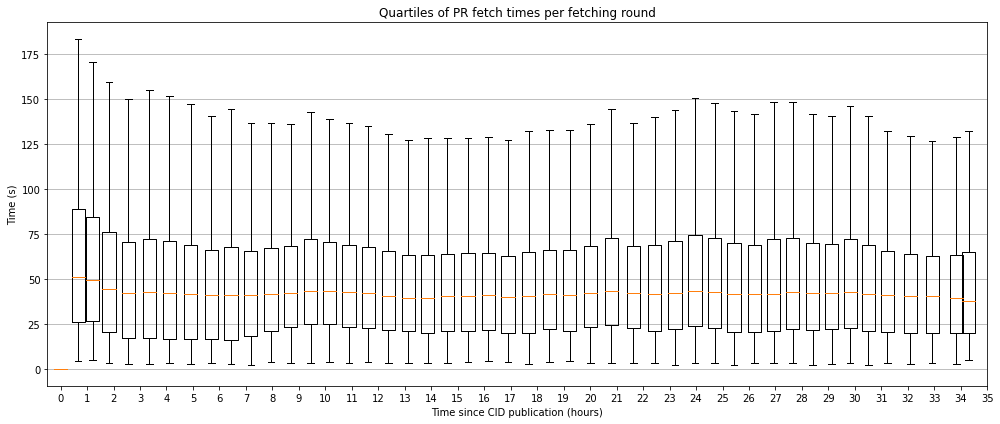

In [146]:
# Get the time to ping PR Holders

# Get the number of rounds that we hoarded
pobj = pd.read_sql_query("select ping_round from fetch_results group by ping_round order by ping_round ASC", db_con)

fetch_time_dist = []
hours_dist = []
# Get the distribution for each of the rounds
for i, row in pobj.iterrows():
    fpd_round_ftime = pd.read_sql_query(f'select cid_hash, fetch_time, fetch_duration from fetch_results where ping_round={row["ping_round"]} order by cid_hash', db_con) 
    fetch_time_dist.append(fpd_round_ftime['fetch_duration'] / 1000 ) # convert to secs 
    
    fpd_round_ftime['time of pub'] = (fpd_round_ftime['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
    pp = fpd_round_ftime['time of pub'].to_numpy()
    hours_dist.append(np.median(pp))
    
fig, ax = plt.subplots()
ax.figure.set_size_inches(14, 6)
ax.boxplot(fetch_time_dist, positions=hours_dist, showfliers=False) 
ax.set_xlabel("Time since CID publication (hours)")

# set net xticks to int hours
ticks = np.arange(np.round(hours_dist[-1])+2)
ax.set_xticks(ticks, ticks.astype(int))
ax.set_ylabel("Time (s)")

plt.title("Quartiles of PR fetch times per fetching round")
plt.grid(axis='y')
plt.tight_layout()
plt.show()



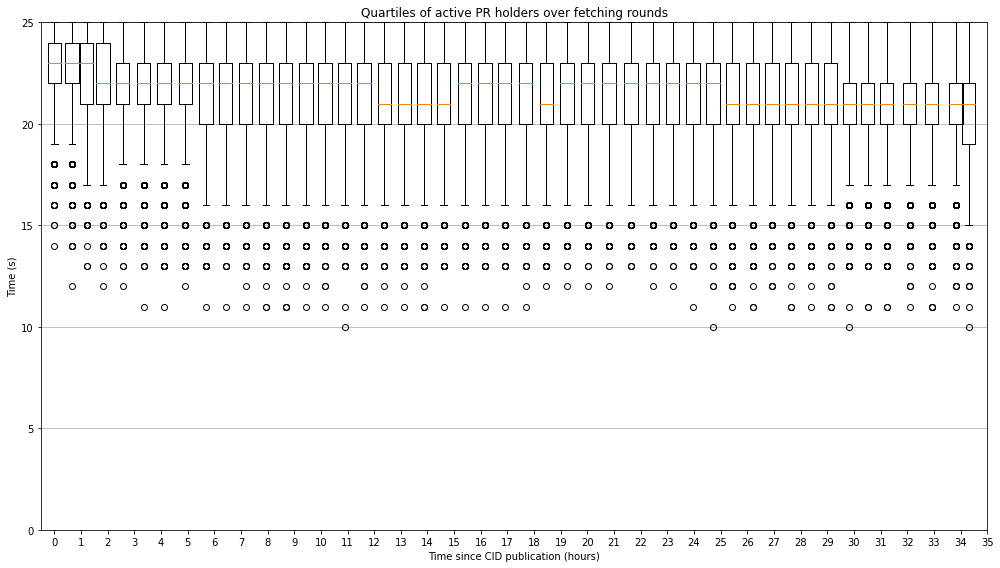

In [147]:

# Get active PR holders over fetch rounds (just for double check following distributions)

# Get the number of rounds that we hoarded
pobj = pd.read_sql_query("select ping_round from fetch_results group by ping_round order by ping_round ASC", db_con)

succ_att_dist = []
hours_dist = []
# Get the distribution for each of the rounds
for i, row in pobj.iterrows():
    p = pd.read_sql_query(f'select cid_hash, fetch_time, success_att from fetch_results where ping_round={row["ping_round"]} order by cid_hash;', db_con) 
    succ_att_dist.append(p['success_att'])

    p['time of pub'] = (p['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
    pp = p['time of pub'].to_numpy()
    hours_dist.append(np.median(pp))
    
fig, ax = plt.subplots(figsize=(14,8))
ax.boxplot(succ_att_dist, positions=hours_dist, showfliers=True) 
ax.set_xlabel("Time since CID publication (hours)") # TODO: hardcoded to 30 mins
ax.set_ylabel("Active PR holders")
ax.set_ylim(0, max(succ_att_dist[0]))

# set net xticks to int hours
ticks = np.arange(np.round(hours_dist[-1])+2)
ax.set_xticks(ticks, ticks.astype(int))
ax.set_ylabel("Time (s)")

plt.title(f"Quartiles of active PR holders over fetching rounds")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


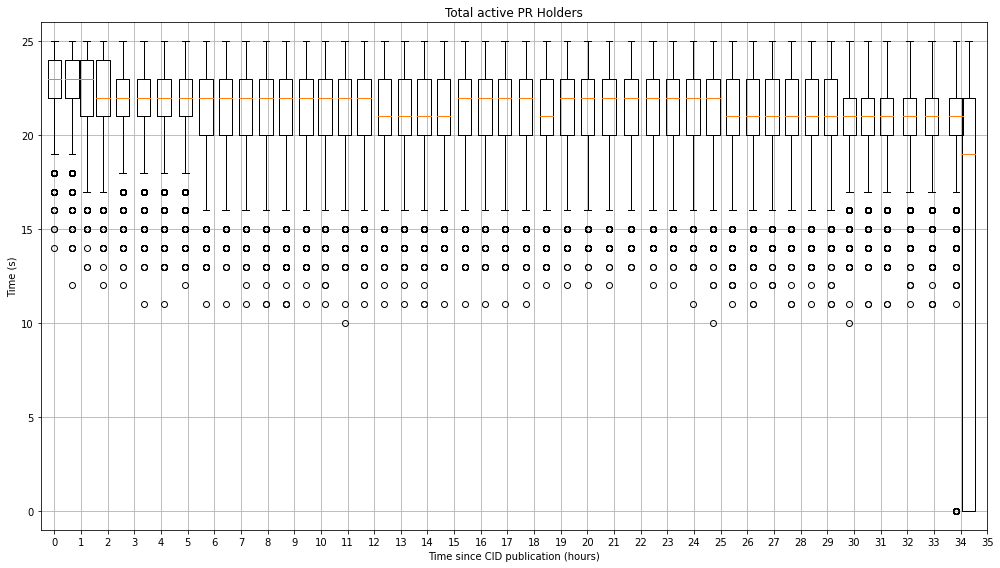

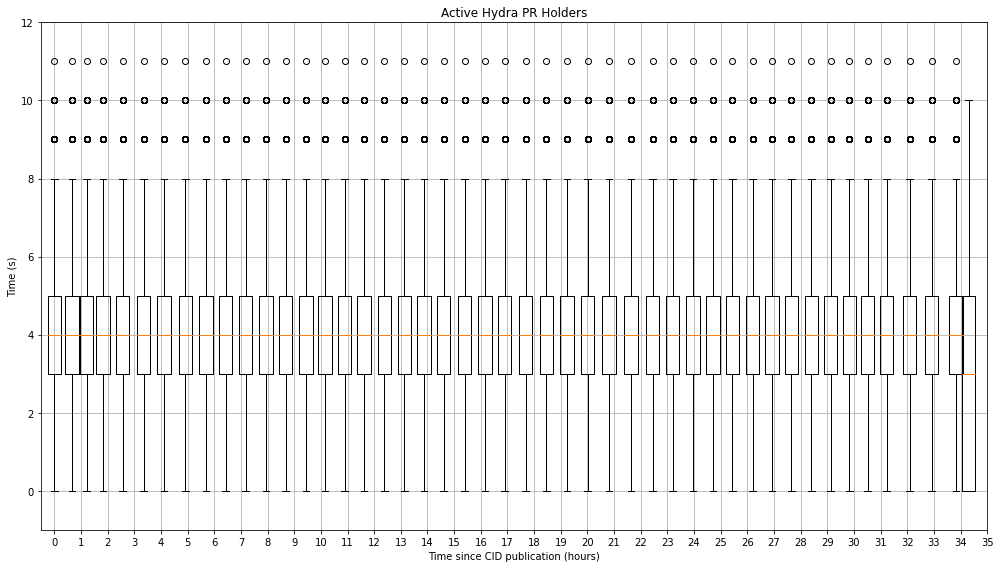

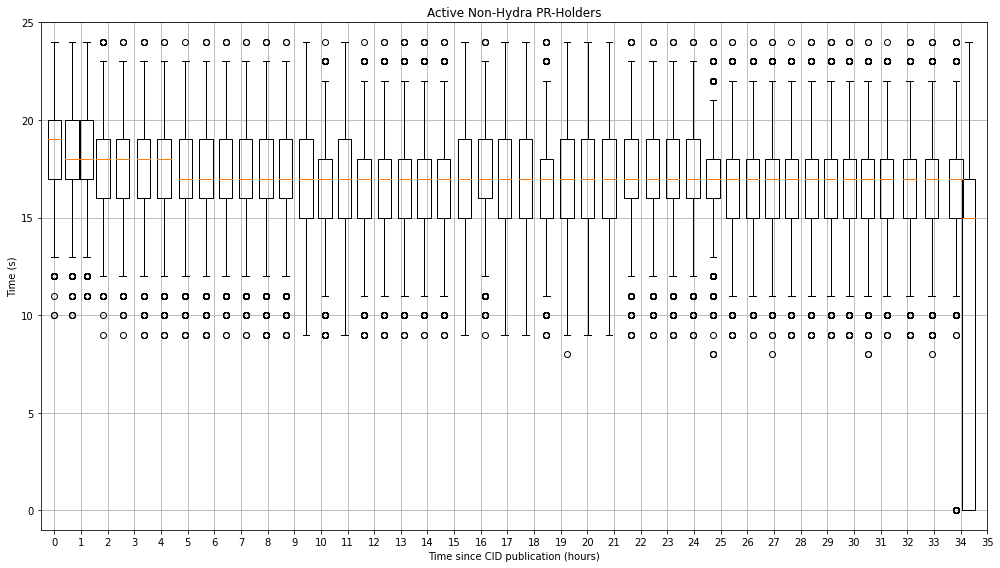

In [148]:
# Get active PR holders over fetch rounds hydra peers

query_set = ["""
    select p.cid_hash, p.ping_round, count(p.is_active) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.is_active from ping_results as r
            left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.is_active=true 
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, count(p.is_active) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.is_active, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.is_active=true and p.client='hydra-booster'
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, count(p.is_active) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.is_active, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.is_active=true and p.client!='hydra-booster'
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
]
title_set = ["Total active PR Holders", "Active Hydra PR Holders", "Active Non-Hydra PR-Holders"]

for item, query_item in enumerate(query_set):
    active_tot = []
    # Iterate through ping rounds to get 
    for idx, row in ping_rounds.iterrows():
        aux_act = []
        active_p = pd.read_sql_query( query_item.replace('{%ping_round%}', str(row['ping_round'])), db_con)
        # Add 0 for those lines without active lines
        for i in range(len(cids) - len(active_p)):
            aux_act.append(0)
        for i, r in active_p.iterrows():
            aux_act.append(r['count'])
        active_tot.append(aux_act)
    
    # active hydras vs active no hydras
    fig, ax = plt.subplots(figsize=(14,8))
    ax.boxplot(active_tot, positions=hours_dist, showfliers=True) 
    ax.set_title(title_set[item])

    # set net xticks to int hours
    ticks = np.arange(np.round(hours_dist[-1])+2)
    ax.set_xticks(ticks, ticks.astype(int))
    ax.set_xlabel("Time since CID publication (hours)")
    ax.set_ylabel("Time (s)")
    ax.set_ylim(-1, max(active_tot[0])+1)

    plt.grid()
    plt.tight_layout()
    plt.show()

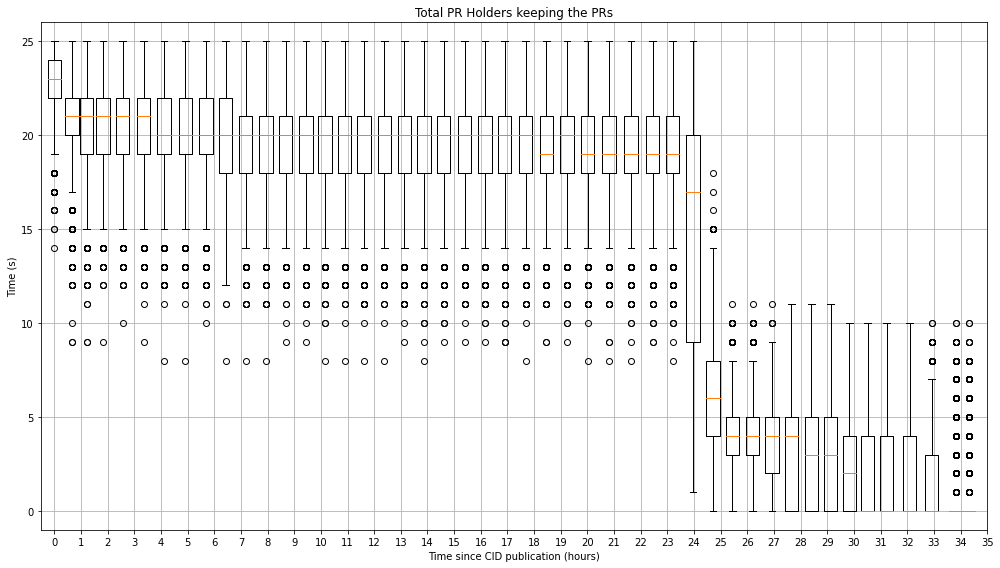

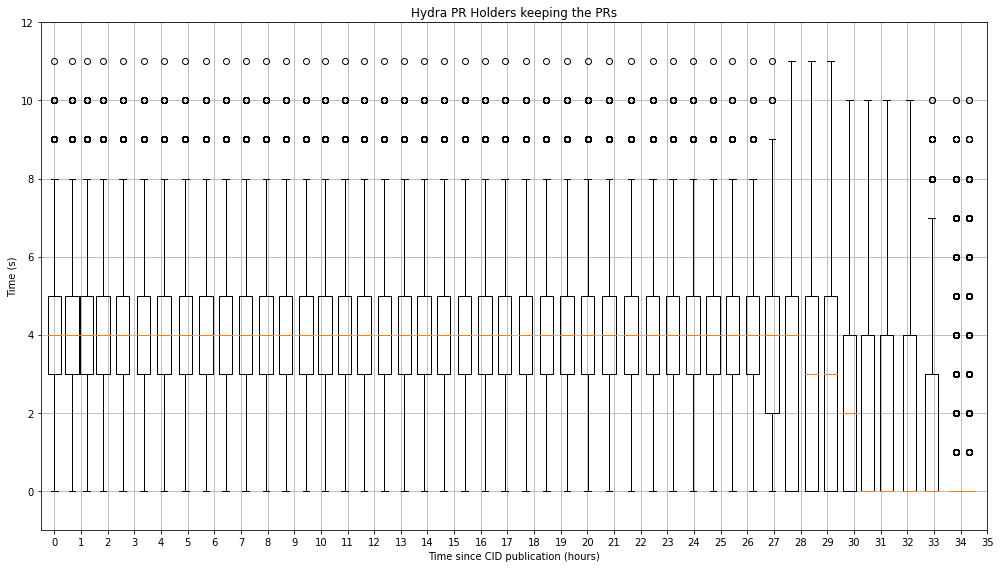

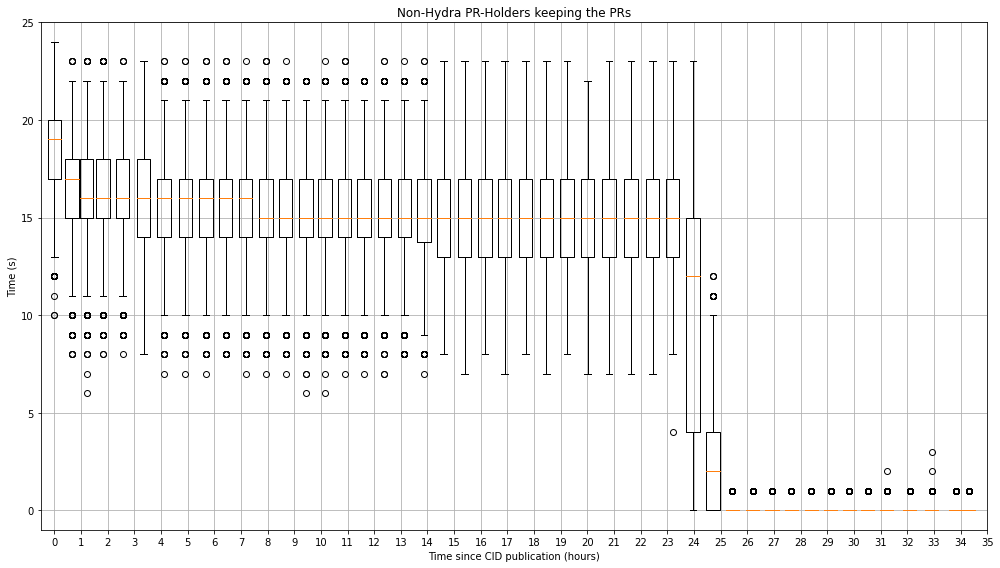

In [149]:
# Get PR holders keeping the PRs over fetch rounds

query_set = ["""
    select p.cid_hash, p.ping_round, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records from ping_results as r
            left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true 
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true and p.client='hydra-booster'
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true and p.client!='hydra-booster'
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
]

title_set = ["Total PR Holders keeping the PRs", "Hydra PR Holders keeping the PRs", "Non-Hydra PR-Holders keeping the PRs"]

for item, query_item in enumerate(query_set):
    active_tot = []
    # Iterate through ping rounds to get 
    for idx, row in ping_rounds.iterrows():
        aux_act = []
        active_p = pd.read_sql_query( query_item.replace('{%ping_round%}', str(row['ping_round'])), db_con)
        # Add 0 for those lines without active lines
        for i in range(len(cids) - len(active_p)):
            aux_act.append(0)
        for i, r in active_p.iterrows():
            aux_act.append(r['count'])
        active_tot.append(aux_act)

    # active hydras vs active no hydras
    fig, ax = plt.subplots(figsize=(14,8))
    ax.boxplot(active_tot, positions=hours_dist, showfliers=True) 
    ax.set_title(title_set[item])

    # set net xticks to int hours
    ticks = np.arange(np.round(hours_dist[-1])+2)
    ax.set_xticks(ticks, ticks.astype(int))
    ax.set_xlabel("Time since CID publication (hours)")
    ax.set_ylabel("Time (s)")
    ax.set_ylim(-1, max(active_tot[0])+1)

    plt.grid()
    plt.tight_layout()
    plt.show()

          client  count  client percentage
0        go-ipfs   9018          63.753977
1  NotIdentified   2805          19.830329
2  hydra-booster   2038          14.407918
3          storm    187           1.322022
4         Others     59           0.417109
5            ioi     38           0.268646


Text(0.5, 1.0, 'Client type on PR Holders')

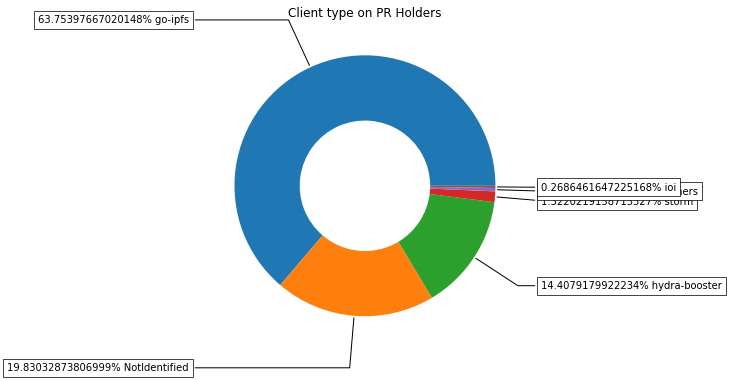

In [150]:
# Get client distribution on PR Holders
pobj = pd.read_sql_query("select client, count(client) from peer_info group by client order by count(client) DESC;", db_con)

total = 0
for i, c in pobj.iterrows():
    total += c["count"]
    
# get the percentage of each client
pobj["client percentage"] = (pobj["count"] * 100) / total
print(pobj)

# compose labels
labels = []
for i, row in pobj.iterrows():
    r = f'{row["client percentage"]}% {row["client"]}'
    labels.append(r)
    
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(pobj['client percentage'], wedgeprops=dict(width=0.5))#, startangle=-40)

# Generate the text boxes with the legend and percentajes 
bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Client type on PR Holders")


          client  count  client_ratio
0        go-ipfs   9018        0.9018
1  NotIdentified   2805        0.2805
2  hydra-booster   2038        0.2038
3          storm    187        0.0187
4         Others     59        0.0059
5            ioi     38        0.0038


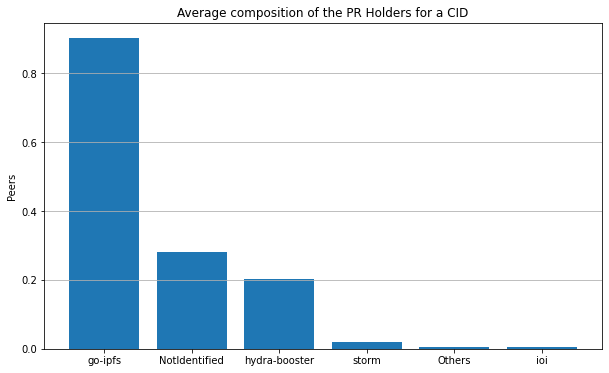

In [151]:
# Get number of Hyda boosters as PR Holders
pobj = pd.read_sql_query("select client, count(client) from peer_info group by client order by count(client) DESC;", db_con)

total = 0
for i, c in pobj.iterrows():
    total += c["count"]
    
# get the percentage of each client
pobj["client_ratio"] = (pobj["count"]) / len(cids)
print(pobj)

# compose labels
labels = []
for i, row in pobj.iterrows():
    r = f'{row["client_ratio"]}% {row["client"]}'
    labels.append(r)

plt.bar(pobj['client'], pobj['client_ratio'])
plt.title("Average composition of the PR Holders for a CID")
plt.ylabel("Peers")
plt.grid(axis='y')
    

Text(0.5, 1.0, 'Error distribution over fetch rounds')

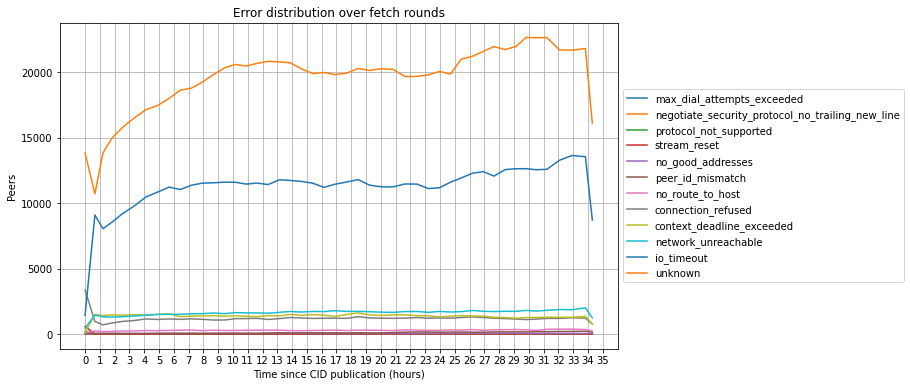

In [152]:
# Check the error getting connecting PR Holders

# get cids
cidobj = pd.read_sql_query('select id, cid_hash from cid_info', db_con)

# get list of errors from the entire pings
errorsobj = pd.read_sql_query('select conn_error, count(conn_error) from ping_results group by conn_error order by count(conn_error)', db_con)

pingsobj = pd.read_sql_query("select ping_round from ping_results group by ping_round order by ping_round ASC", db_con)

err_dist = {}
for i, r in errorsobj.iterrows():
    err_dist[r['conn_error']] = []
    
for i, r in pingsobj.iterrows():
    errorsobj = pd.read_sql_query(f'select conn_error, count(conn_error) from ping_results where ping_round={r["ping_round"]} group by conn_error order by count(conn_error) ASC', db_con)
    
    # Add zero round to all errors (keep the actual distribution)
    for err in err_dist:
        err_dist[err].append(0)
    
    # Add actual value of the error
    for idx, row in errorsobj.iterrows():
        err_dist[row["conn_error"]][i] = row["count"]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for k in err_dist:
    if k == 'none':
        continue
    ax.plot(hours_dist, err_dist[k], label=k)
    
ax.set_xlabel('Time since CID publication (hours)')
ax.set_ylabel('Peers')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# set net xticks to int hours
ticks = np.arange(np.round(hours_dist[-1])+2)
ax.set_xticks(ticks, ticks.astype(int))

plt.grid()
plt.title('Error distribution over fetch rounds')



    


In [153]:
pobj = pd.read_sql_query(
    """select i.user_agent, r.has_records, count(i.user_agent) from ping_results as r
    left join peer_info as i on r.peer_id=i.peer_id 
    where r.ping_round=60 and r.has_records=true 
    group by i.user_agent, r.has_records
    ;""", db_con) 
print(pobj)

Empty DataFrame
Columns: [user_agent, has_records, count]
Index: []


In [ ]:
db_con.close()